## Corona Cases Forecasting for Germany on a County Level
### Visualize data based on county:

In [47]:
import pandas as pd 
import geopandas as gpd
import descartes # to plot
import numpy as np
import matplotlib.pyplot as plt
import os, sys, inspect
plt.style.use('seaborn')
%matplotlib inline

# autoreload packages
%load_ext autoreload
%autoreload 2

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from preprocessing import *
from plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Get Corona data:
RKI_Corona_Landkreise.csv:

GEN                   | NUTS  | cases | deaths | county
--------------------- | ----- | ----- | ------ | ----------
Flensburg             | DEF06 | 21    | 0      |  SK Flensburg <br>
Herzogtum Lauenburg   | DEF07 | 15    | 0      |  LK Herzogtum Lauenburg


df_time: 

Landkreis                 | AnzahlFall | AnzahlTodesfall | Meldedatum               | IdLandkreis | NUTS3  | Bevoelkerung
------------------------- | ---------- | --------------- | ------------------------ | ----------- | ------ | ------------
SK Magdeburg              | 2          | 0               | 2020-03-18T00:00:00.000Z | 15003       | NaN    | NaN
SK Magdeburg              | 1          | 0               | 2020-03-12T00:00:00.000Z | 15003       | NaN    | NaN
LK Altmarkkreis Salzwedel | 1          | 0               | 2020-03-12T00:00:00.000Z | 15081       | NaN    | NaN

In [48]:
#data = pd.read_csv("data/RKI_Corona_Landkreise.csv")
df_time = pd.read_csv("data/df_time.csv")
#df_time.head(2)
#data.describe()

##### Get additional information about the Counties:
e.g. population density, public transport information, gender distribution, age distribution

### Load county shape information

https://public.opendatasoft.com/explore/dataset/landkreise-in-germany/export/

most important: cca_2 (= county identifier) and geometry:

name_2                   | cca_2  | geometry
------------------------ | ------ | -------------------------------------------------
Freiburg im Breisgau     | 08311  | POLYGON ((7.790447235107478 47.96881103515624,...
Dillingen an der Donau   | 09773  | POLYGON ((10.6144847869873 48.75083541870145, ...


In [49]:
county_df = gpd.read_file('data/landkreise-in-germany.shp', encoding='utf-8', dtype={'cca_2': str})
# convert cca_2 to float for merge later
county_df = county_df.astype({'cca_2': 'float64'})
#county_df.head(2)

### Aggregate Information for different dates

In [50]:
# aggregate number of cases by until any date
df_time  = df_time.astype({'IdLandkreis': 'float64'})
df_agg = df_time.sort_values(['IdLandkreis','Meldedatum'],ascending=False)\
    .groupby(['IdLandkreis','Meldedatum'])\
    .agg({'AnzahlFall':sum})\
    .groupby('IdLandkreis').cumsum().reset_index()

### Merge Geometric and Corona Information and plot:

#### Plot for individual date:

In [51]:
#Plot for individual date:
date = "2020-03-20T00:00:00.000Z"
df_date = cases_at_date(df_agg, date)
df = pd.merge(left=county_df , right= df_date, how='left', left_on='cca_2', right_on='IdLandkreis')
df['AnzahlFall'][df['AnzahlFall'].isna()] = 0 # set na values to zero
#df.head(3)

/Users/Paul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


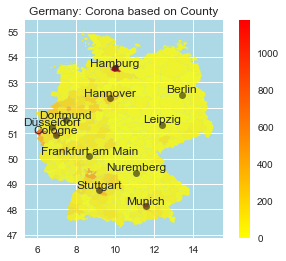

In [53]:
plot_map(df, "AnzahlFall")

#### Plot for all dates:

In [54]:
date_1   = df_time['Meldedatum'].min()
date_cur = df_time['Meldedatum'].max()

In [57]:
county_df.head()

id_0  iso   name_0  id_1             name_1   id_2  \
0  86.0  DEU  Germany   1.0  Baden-Württemberg   12.0   
1  86.0  DEU  Germany   2.0             Bayern   68.0   
2  86.0  DEU  Germany   2.0             Bayern  107.0   
3  86.0  DEU  Germany   2.0             Bayern  110.0   
4  86.0  DEU  Germany   2.0             Bayern  122.0   

                      name_2    hasc_2  ccn_2   cca_2            type_2  \
0       Freiburg im Breisgau  DE.BW.FB    0.0  8311.0        Stadtkreis   
1     Dillingen an der Donau  DE.BY.DD    0.0  9773.0         Landkreis   
2                   Nürnberg  DE.BY.NR    0.0  9564.0  Kreisfreie Stadt   
3  Neumarkt in der Oberpfalz  DE.BY.NO    0.0  9373.0         Landkreis   
4                  Rosenheim  DE.BY.RH    0.0  9163.0  Kreisfreie Stadt   

  engtype_2 nl_name_2 varname_2  \
0  District      None      None   
1  District      None      None   
2  District      None      None   
3  District      None      None   
4  District      None      None   

                                            geometry  
0  POLYGON ((7.79045 47.96881, 7.78610 47.96866, ...  
1  POLYGON ((10.61448 48.75084, 10.61411 48.74994...  
2  MULTIPOLYGON (((11.18831 49.38963, 11.18645 49...  
3  POLYGON ((11.46063 49.42604, 11.46161 49.42276...  
4  POLYGON ((12.05431 47.81771, 12.05556 47.81853...

In [64]:
dates = df_time['Meldedatum'].sort_values().astype({'Meldedatum': 'str'}).unique()
cases_at_date(df_agg,dates[-1]).head(100)

IdLandkreis  AnzahlFall
0        1001.0          12
1        1002.0          36
2        1003.0          21
3        1004.0           1
4        1051.0          12
..          ...         ...
95       5566.0         200
96       5570.0         166
97       5711.0          22
98       5754.0         202
99       5758.0          70

[100 rows x 2 columns]

/Users/Paul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Paul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Paul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__'

/Users/Paul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Paul/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/Paul/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

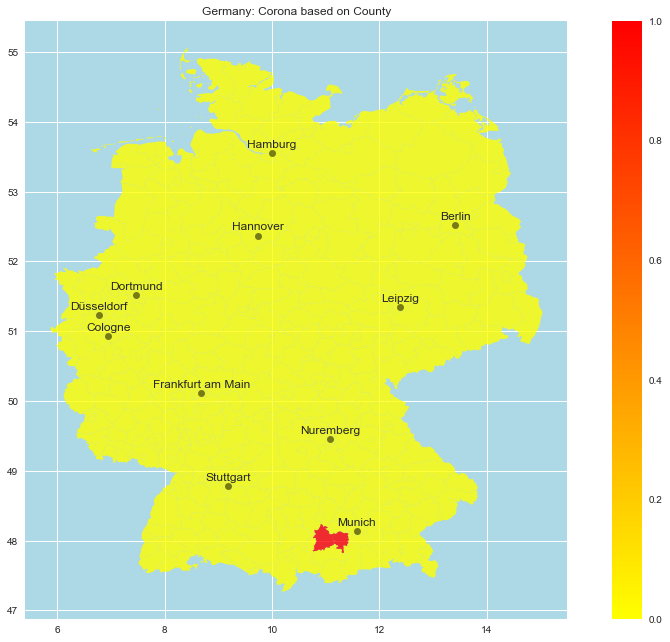

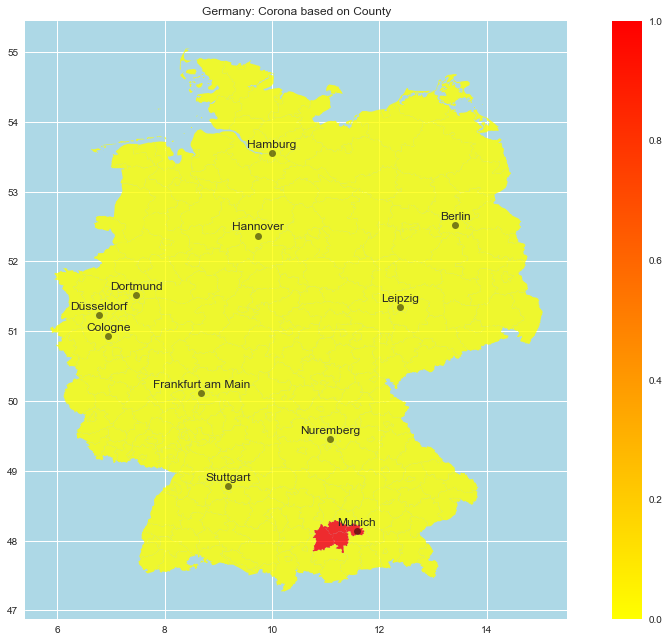

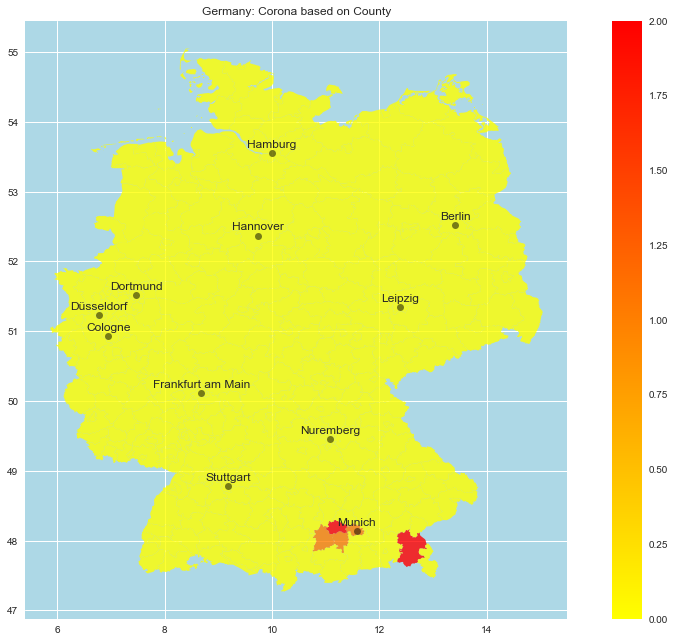

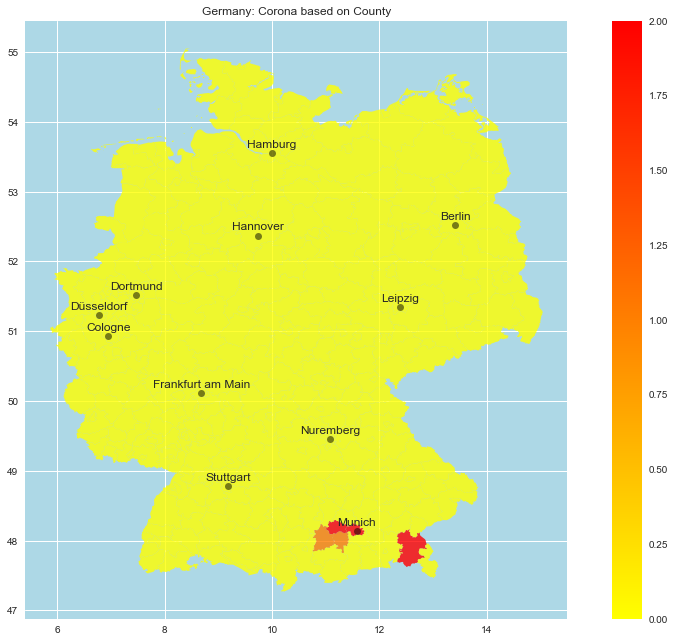

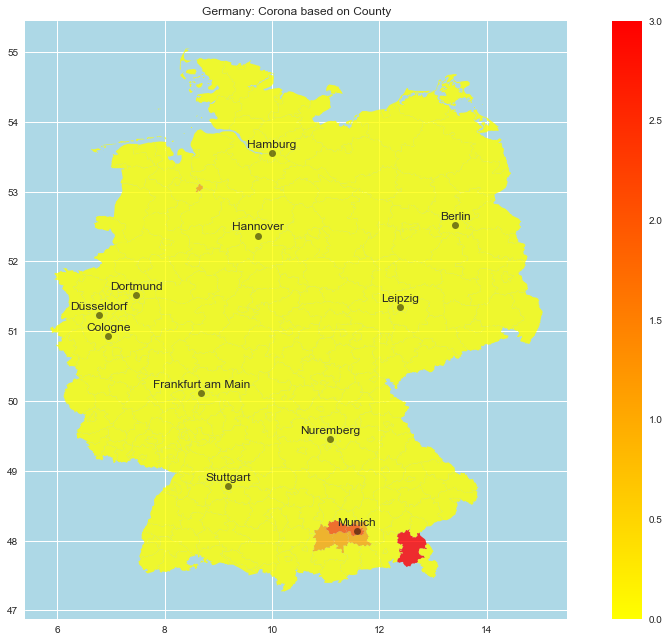

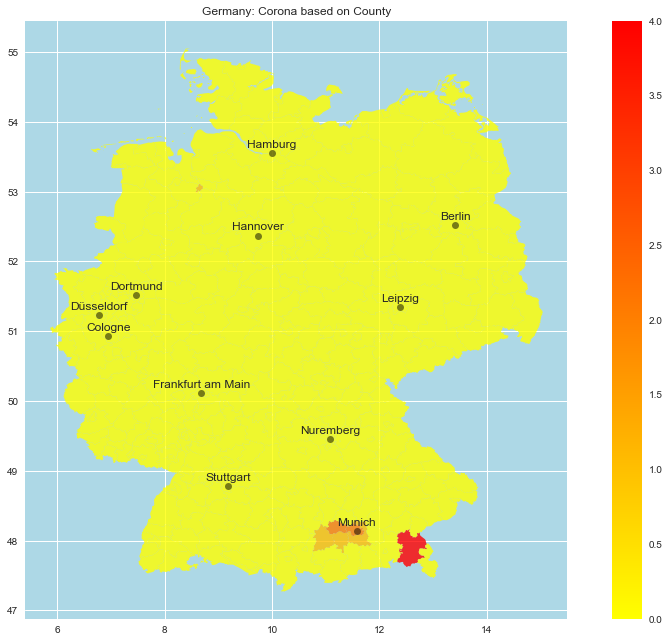

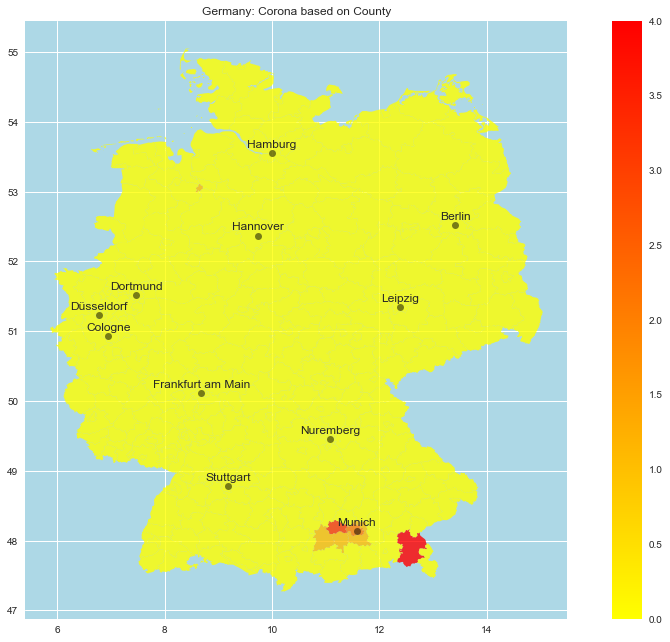

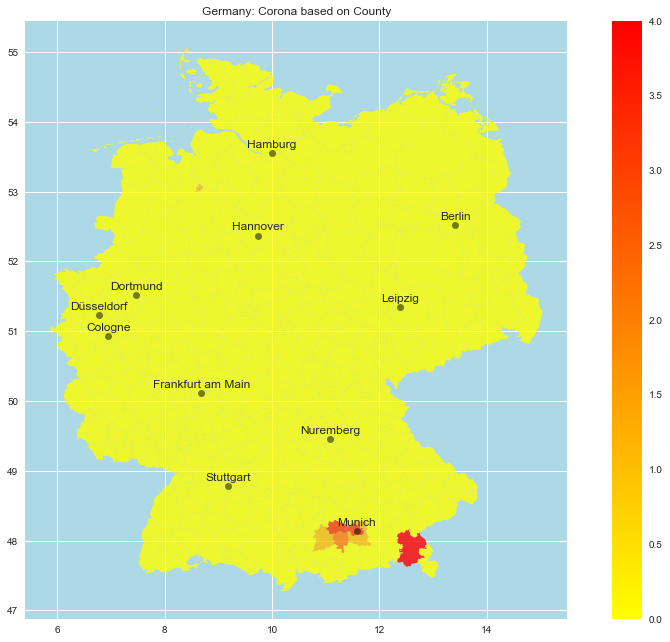

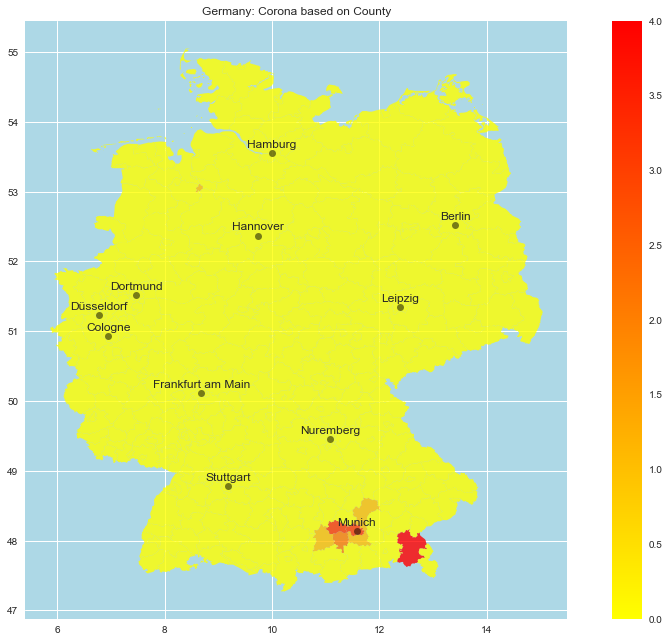

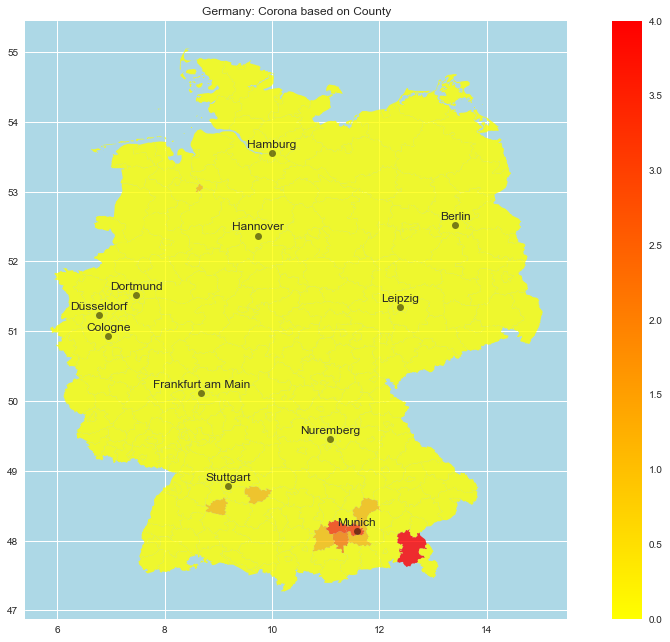

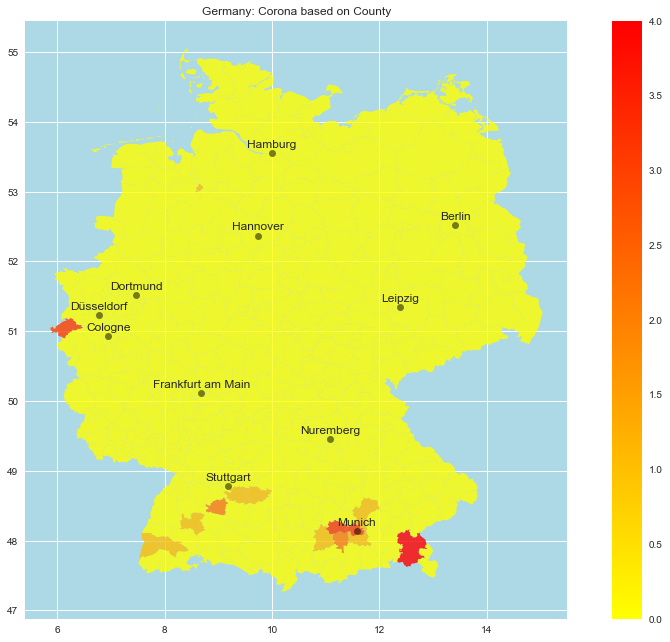

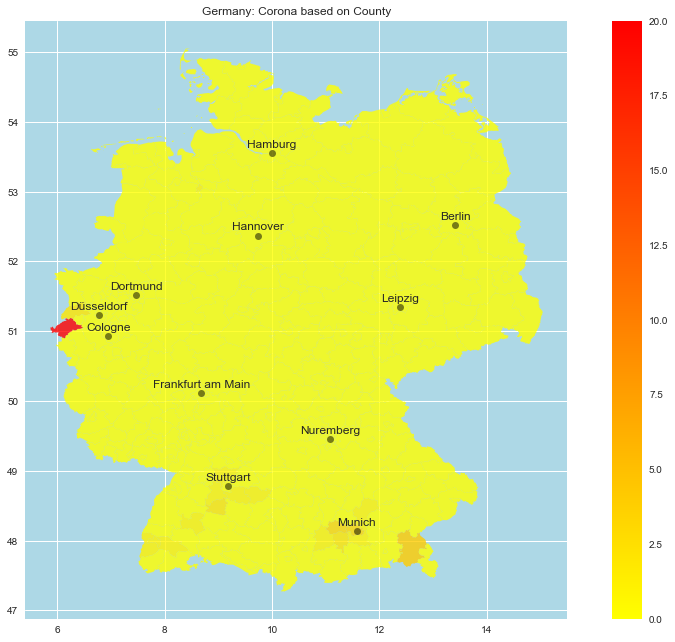

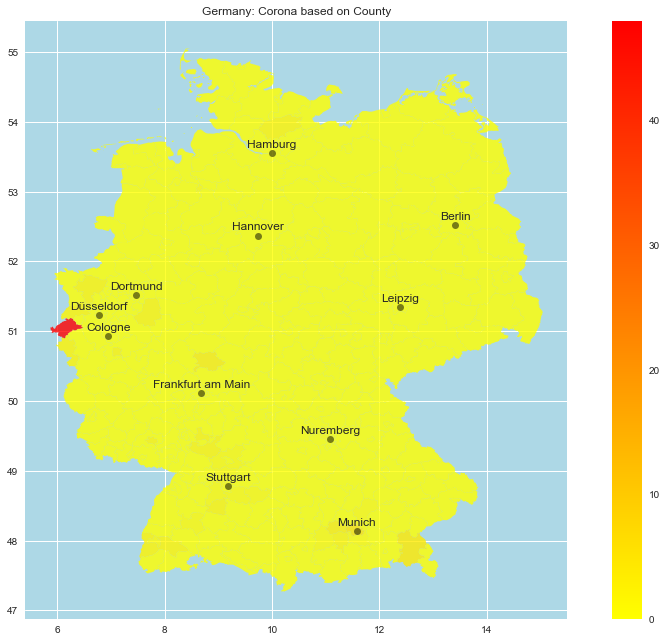

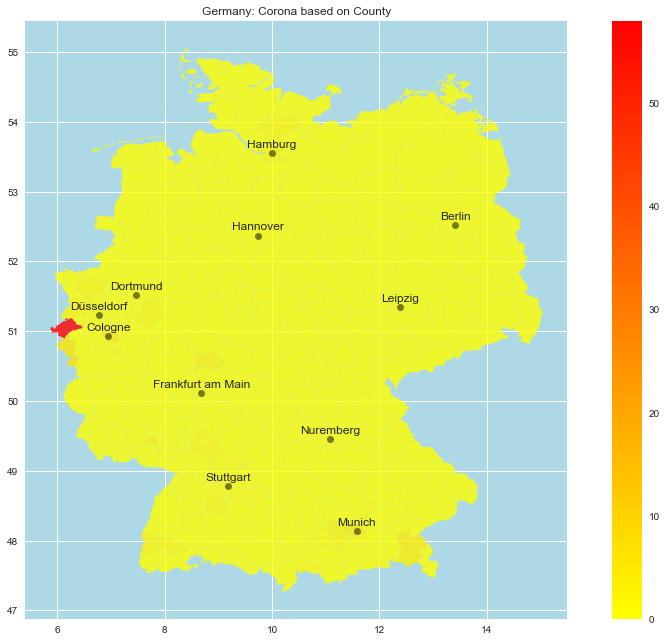

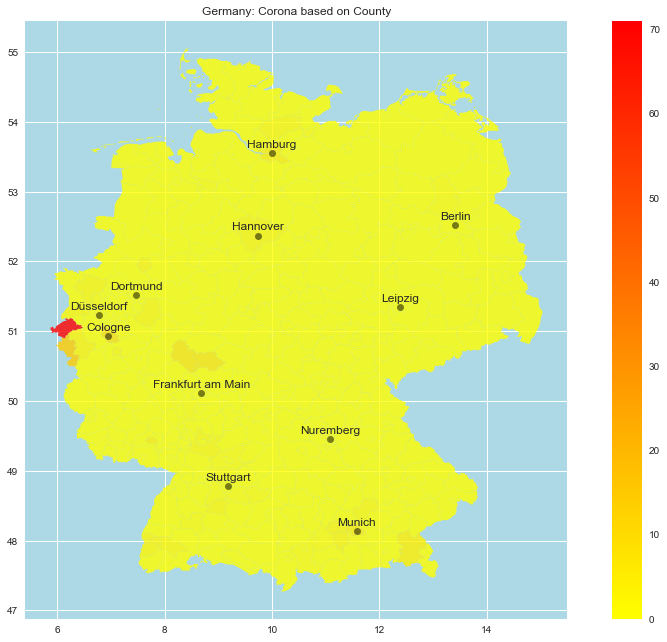

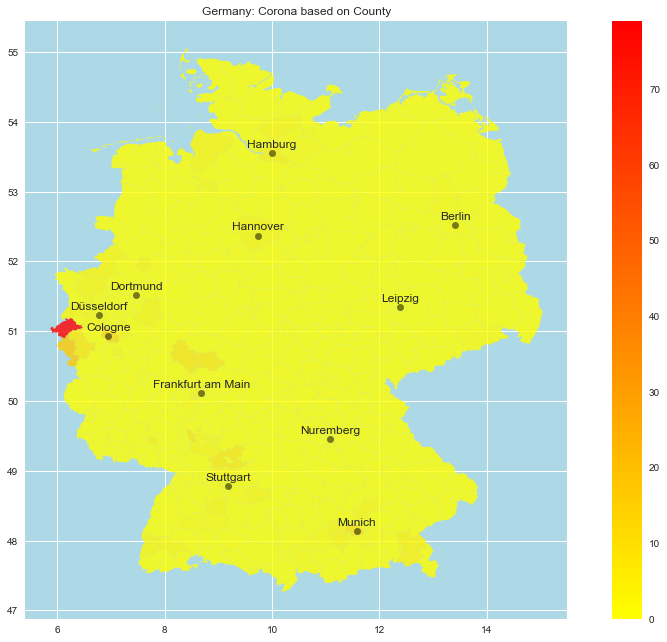

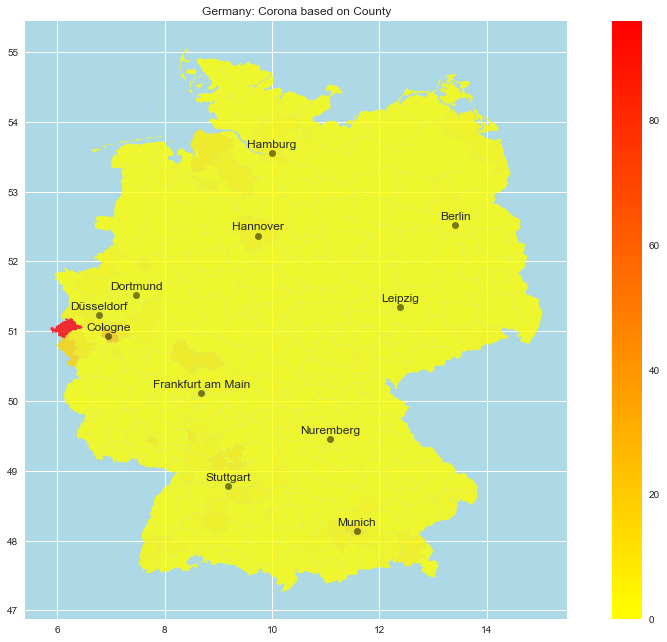

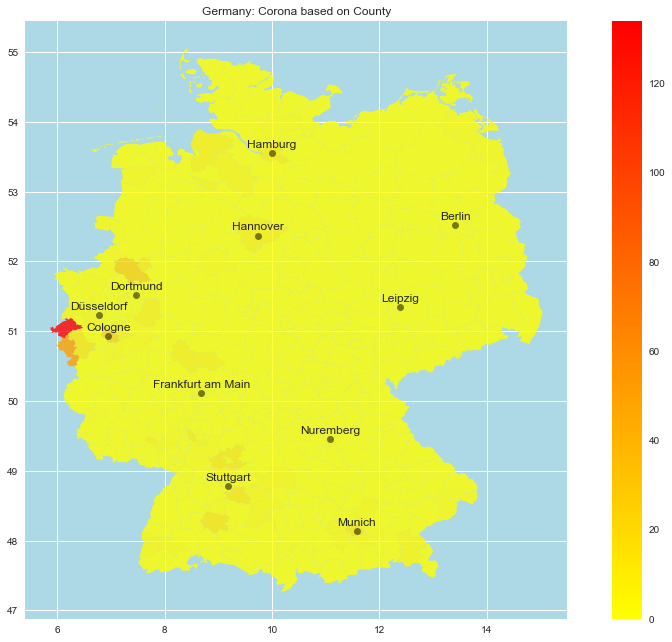

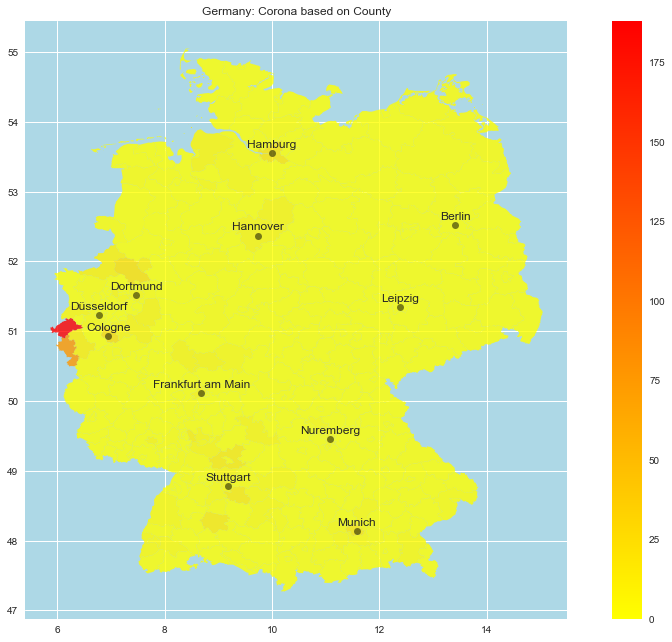

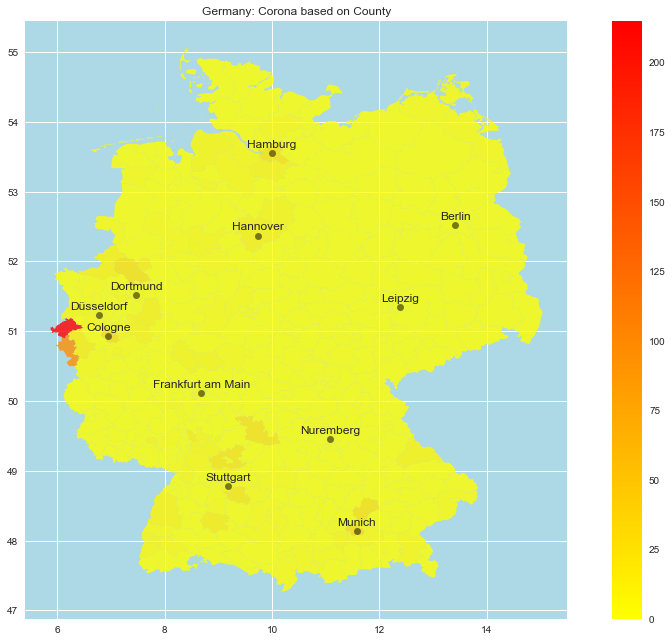

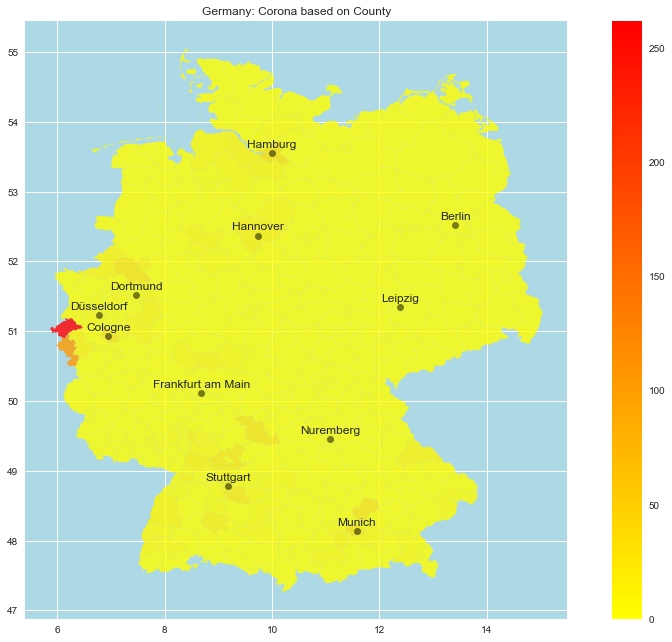

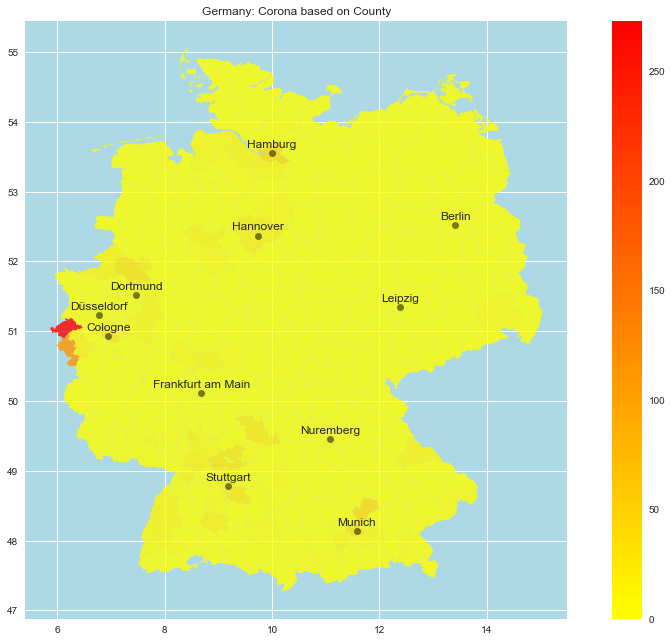

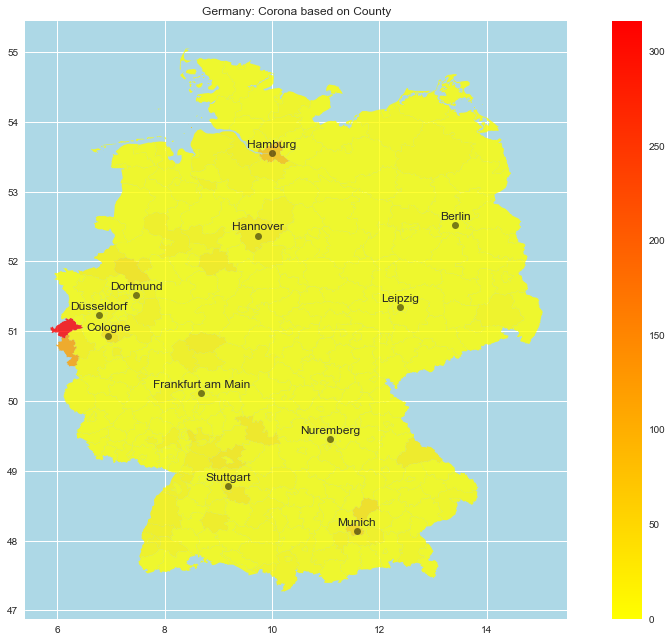

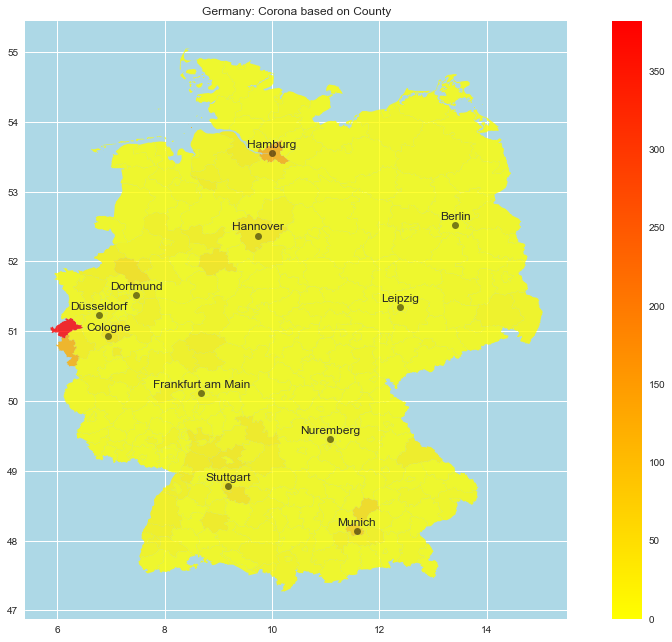

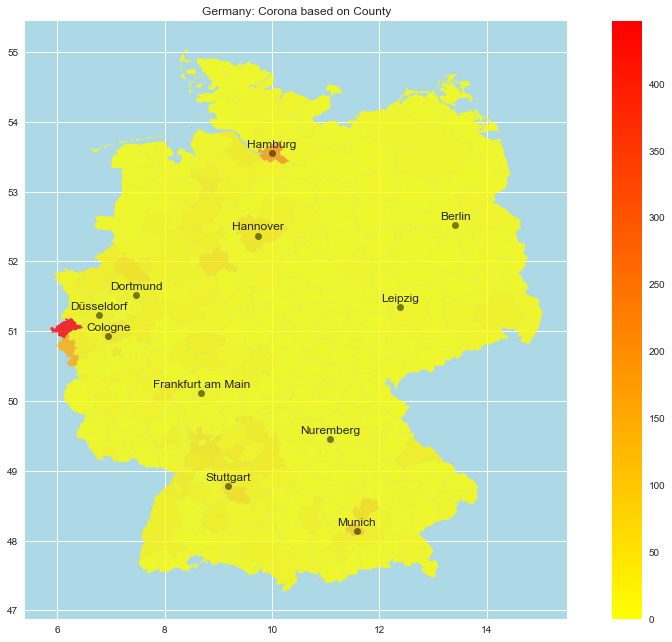

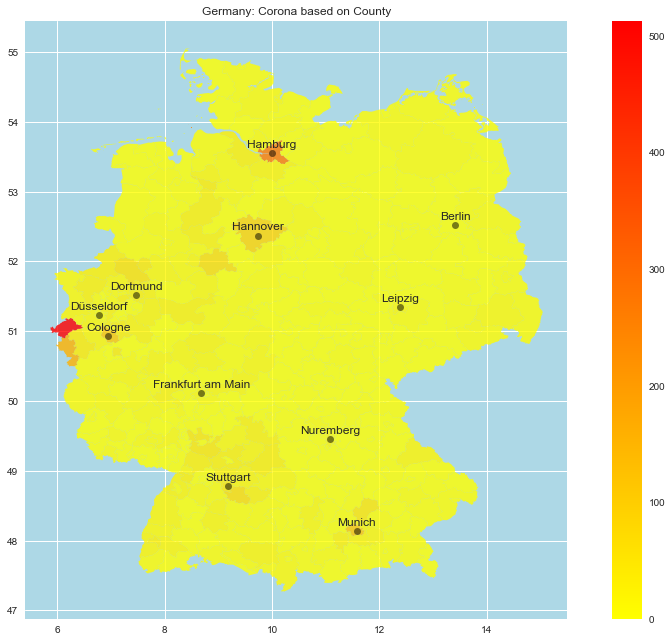

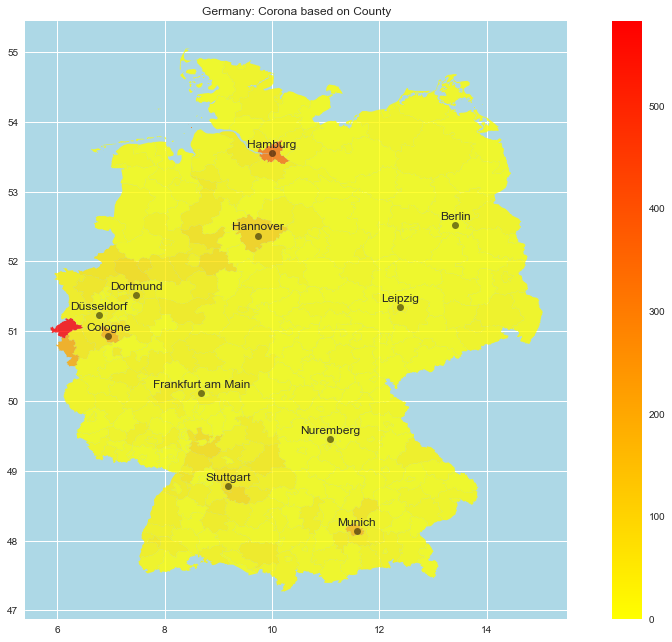

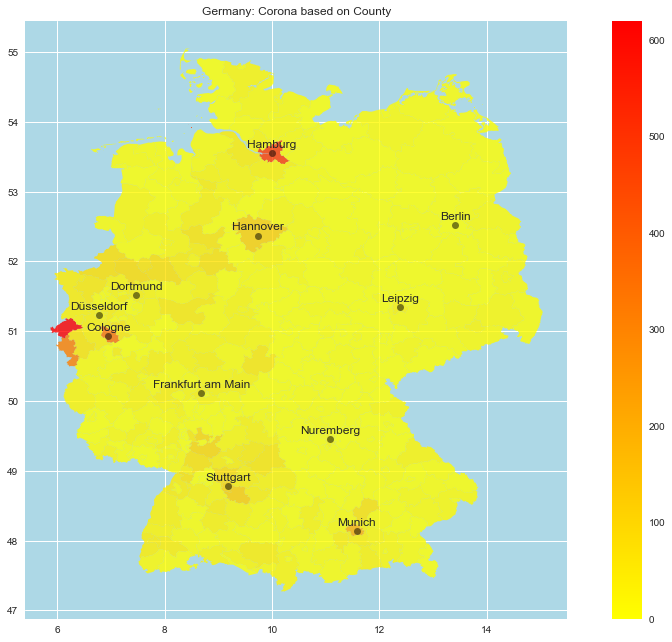

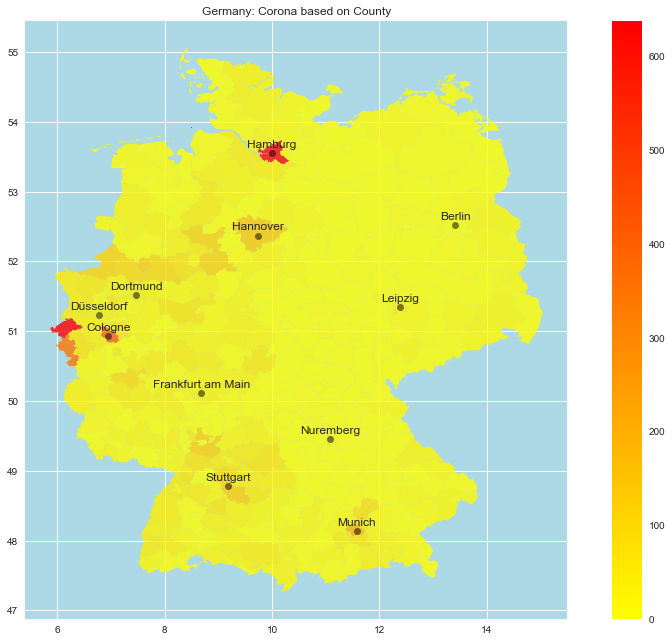

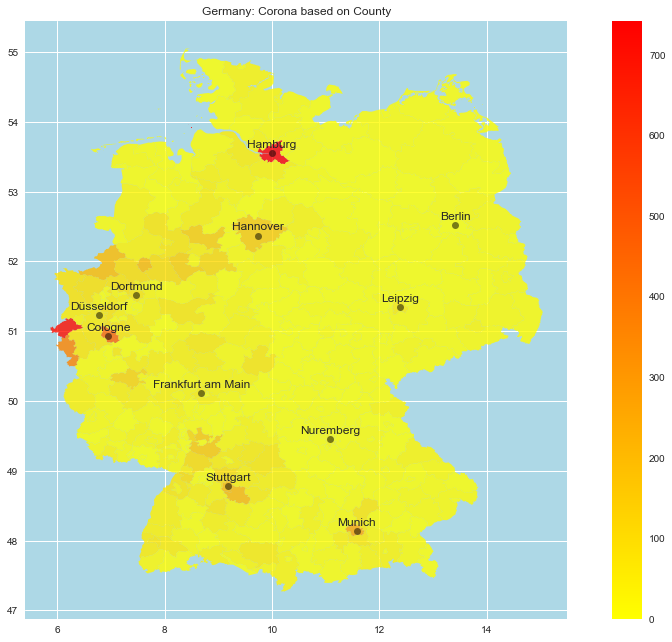

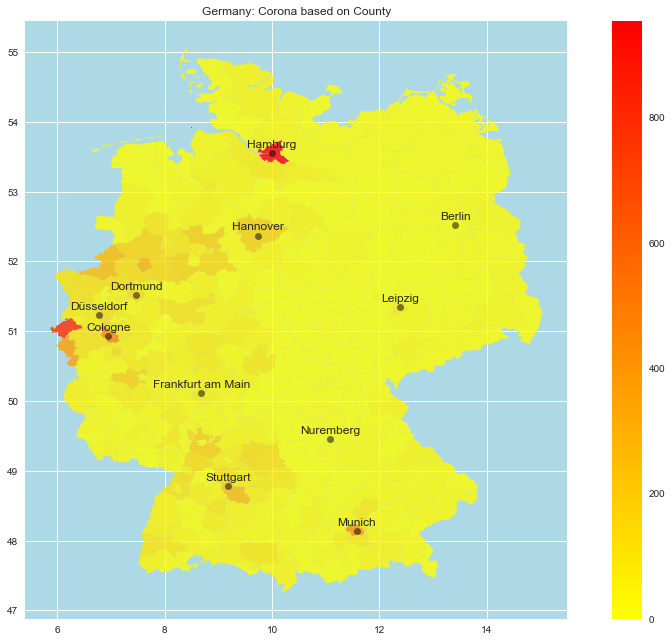

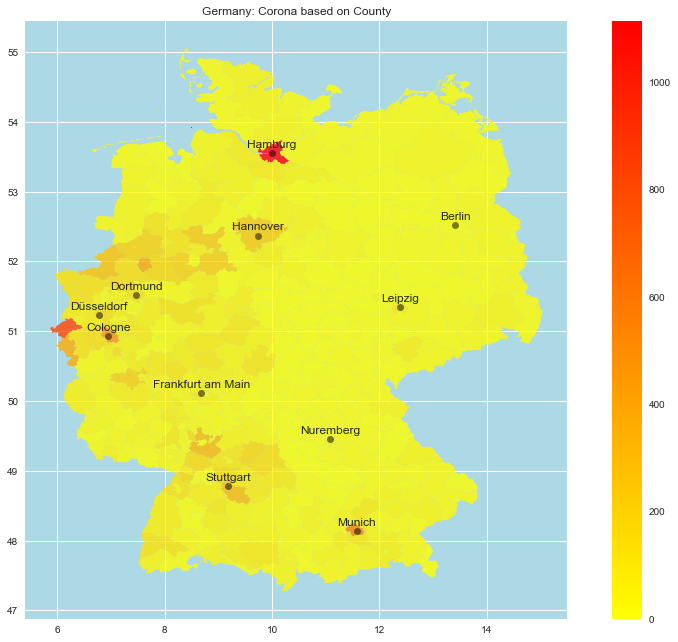

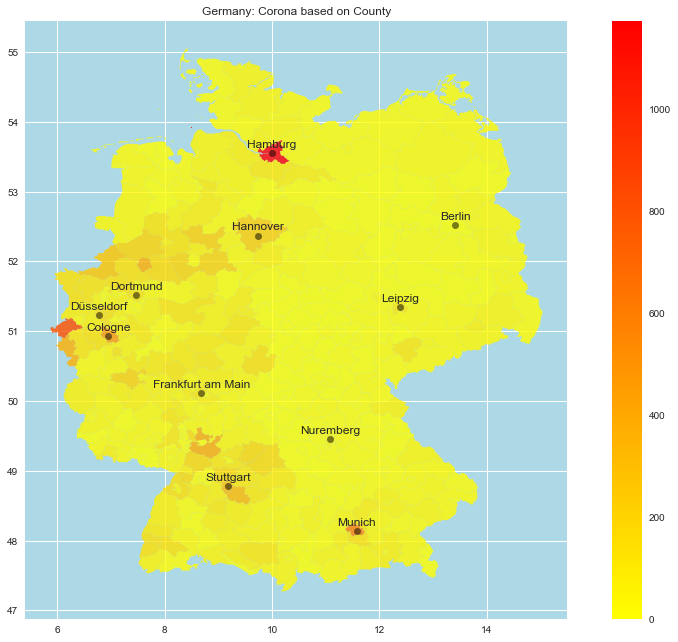

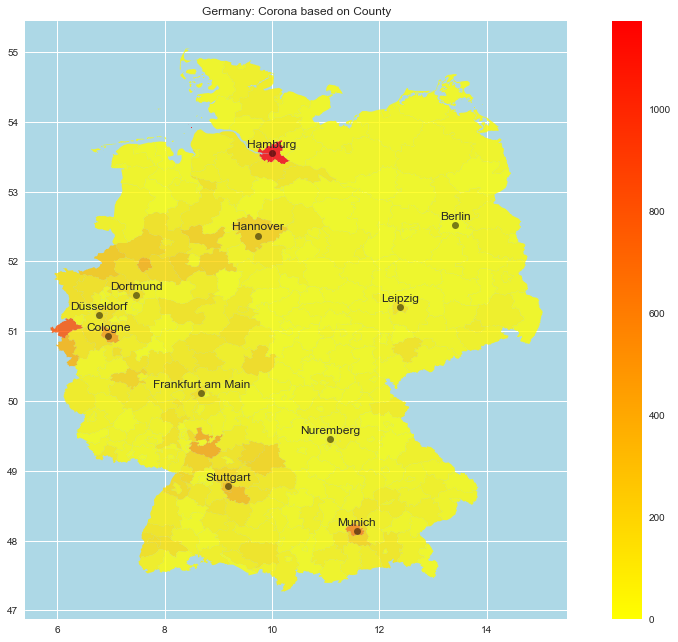

In [55]:
# plot for all dates:
import time
dates = df_time['Meldedatum'].sort_values().astype({'Meldedatum': 'str'}).unique()

plt.rcParams['figure.figsize'] = [16, 11]
for date in dates:
    df_date = cases_at_date(df_agg,date)
    county_df = pd.merge(left=county_df , right= df_date, how='left', left_on='cca_2', right_on='IdLandkreis')
    df['AnzahlFall'][df['AnzahlFall'].isna()] = 0 # set na values to zero
    plot_map(df, "AnzahlFall")
    time.sleep(2)

In [56]:
df.head()

id_0  iso   name_0  id_1             name_1   id_2  \
0  86.0  DEU  Germany   1.0  Baden-Württemberg   12.0   
1  86.0  DEU  Germany   2.0             Bayern   68.0   
2  86.0  DEU  Germany   2.0             Bayern  107.0   
3  86.0  DEU  Germany   2.0             Bayern  110.0   
4  86.0  DEU  Germany   2.0             Bayern  122.0   

                      name_2    hasc_2  ccn_2   cca_2            type_2  \
0       Freiburg im Breisgau  DE.BW.FB    0.0  8311.0        Stadtkreis   
1     Dillingen an der Donau  DE.BY.DD    0.0  9773.0         Landkreis   
2                   Nürnberg  DE.BY.NR    0.0  9564.0  Kreisfreie Stadt   
3  Neumarkt in der Oberpfalz  DE.BY.NO    0.0  9373.0         Landkreis   
4                  Rosenheim  DE.BY.RH    0.0  9163.0  Kreisfreie Stadt   

  engtype_2 nl_name_2 varname_2  \
0  District      None      None   
1  District      None      None   
2  District      None      None   
3  District      None      None   
4  District      None      None   

                                            geometry  IdLandkreis  AnzahlFall  
0  POLYGON ((7.79045 47.96881, 7.78610 47.96866, ...       8311.0       150.0  
1  POLYGON ((10.61448 48.75084, 10.61411 48.74994...       9773.0         6.0  
2  MULTIPOLYGON (((11.18831 49.38963, 11.18645 49...       9564.0        67.0  
3  POLYGON ((11.46063 49.42604, 11.46161 49.42276...       9373.0        18.0  
4  POLYGON ((12.05431 47.81771, 12.05556 47.81853...       9163.0         1.0